In [23]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
import torch
import torch.nn as nn
from google.colab import files

In [89]:
uploaded = files.upload()
df_data = pd.read_csv(Path("oasis_cross-sectional.csv"))

In [90]:
def extract_basic_info(df_dataset):
    # TODO
    no_of_instances, no_of_attibutes = df_dataset.shape
    no_of_numeric = df_dataset.select_dtypes(include=[np.number]).shape[1]
    no_of_categorical = df_dataset.select_dtypes(exclude=[np.number]).shape[1]
    total_memory = df_dataset.memory_usage(index=False, deep=True).sum()

    return no_of_instances, no_of_attibutes, no_of_numeric, no_of_categorical, total_memory

In [91]:
extract_basic_info(df_data)

(436, 12, 9, 3, np.int64(102024))

In [92]:
# Remove last 20 rows (reliability data)
df_data = df_data.iloc[:-20]

In [93]:
extract_basic_info(df_data)

(416, 12, 9, 3, np.int64(97344))

In [94]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      416 non-null    object 
 1   M/F     416 non-null    object 
 2   Hand    416 non-null    object 
 3   Age     416 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    416 non-null    int64  
 9   nWBV    416 non-null    float64
 10  ASF     416 non-null    float64
 11  Delay   0 non-null      float64
dtypes: float64(7), int64(2), object(3)
memory usage: 39.1+ KB


In [95]:
# Drop Delay, Educ and SES column because of missing values
df_data.drop("Delay", axis=1, inplace=True)
df_data.drop("Educ", axis=1, inplace=True)
df_data.drop("SES", axis=1, inplace=True)

In [96]:
# MMSE and CDR are important attributes and cannot drop rows due to small dataset
# Seems like almost all missing values belong to younger subjects.

# Check correlation with age
df_data['is_missing'] = df_data['CDR'].isna()
print("Check CDR correlation with age")
print(df_data.groupby(pd.cut(df_data['Age'], bins=[0,20,40,60,80,100]))['is_missing'].mean())

df_data['is_missing'] = df_data['MMSE'].isna()
print("\nCheck MMSE correlation with age")
print(df_data.groupby(pd.cut(df_data['Age'], bins=[0,20,40,60,80,100]))['is_missing'].mean())

df_data.drop("is_missing", axis=1, inplace=True)

Check CDR correlation with age
Age
(0, 20]      1.000000
(20, 40]     0.982143
(40, 60]     0.421875
(60, 80]     0.000000
(80, 100]    0.000000
Name: is_missing, dtype: float64

Check MMSE correlation with age
Age
(0, 20]      1.000000
(20, 40]     0.982143
(40, 60]     0.421875
(60, 80]     0.000000
(80, 100]    0.000000
Name: is_missing, dtype: float64


/tmp/ipython-input-713214132.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_data.groupby(pd.cut(df_data['Age'], bins=[0,20,40,60,80,100]))['is_missing'].mean())
/tmp/ipython-input-713214132.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_data.groupby(pd.cut(df_data['Age'], bins=[0,20,40,60,80,100]))['is_missing'].mean())


In [97]:
# Model-based imputation
# Use regression/KNN/MICE imputers that can leverage other variables
# (age) to predict the missing attribute.

from sklearn.impute import KNNImputer

# Select features that help predict the missing attribute
features = ['Age', 'CDR', 'MMSE']

# Subset the DataFrame
df_subset = df_data[features]

# Initialize imputer
imputer = KNNImputer(n_neighbors=5)

# Fit + transform
df_imputed = pd.DataFrame(imputer.fit_transform(df_subset), columns=features)

# Replace only the target column in the original df
df_data['CDR'] = df_imputed['CDR']
df_data['MMSE'] = df_imputed['MMSE']


In [98]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      416 non-null    object 
 1   M/F     416 non-null    object 
 2   Hand    416 non-null    object 
 3   Age     416 non-null    int64  
 4   MMSE    416 non-null    float64
 5   CDR     416 non-null    float64
 6   eTIV    416 non-null    int64  
 7   nWBV    416 non-null    float64
 8   ASF     416 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 29.4+ KB


In [99]:
df_data.head()

,ID,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,R,74,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,R,55,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,R,73,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,M,R,28,29.4,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,M,R,18,29.4,0.0,1737,0.848,1.010


In [100]:
# Check correlation coefficients between the other attributes and target attribute CDR
columns_list = df_data.columns.tolist()
print(columns_list)

corr_matrix_col = columns_list

corr_matrix = df_data[corr_matrix_col].corr(numeric_only=True) #Need to set numeric_only to True with Pandas 2.0
corr_matrix['CDR'].sort_values(ascending=False)

['ID', 'M/F', 'Hand', 'Age', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


,CDR
CDR,1.000000
Age,0.491568
eTIV,0.004968
ASF,-0.012896
nWBV,-0.605135
MMSE,-0.791095


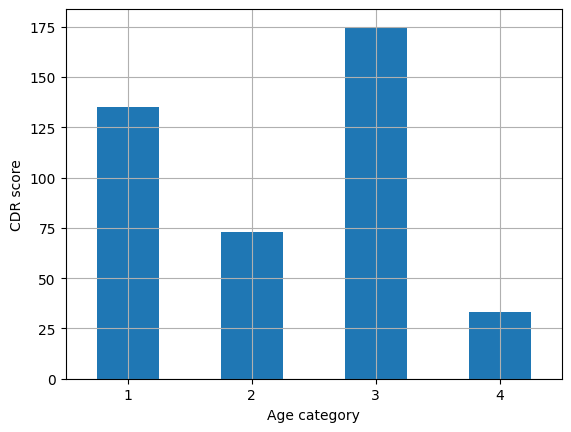

In [101]:
median = df_data['Age'].median()
df_data['Age_cat'] = pd.cut(df_data['Age'],
                               bins=[0., median*0.5, median, median*1.5, np.inf],
                               labels=[1, 2, 3, 4])

df_data['Age_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Age category")
plt.ylabel("CDR score")
plt.show()

In [102]:
# Split train, validation and test sets with stratify sampling
strat_train_set, strat_test_set = train_test_split(df_data,
                                                   test_size=0.2,
                                                   stratify=df_data['Age_cat'])
strat_train_set, strat_valid_set = train_test_split(strat_train_set,
                                                    test_size=0.25,
                                                    stratify=strat_train_set['Age_cat'])

# Split train and test sets randomly (without stratify sampling)
train_set, test_set = train_test_split(df_data, test_size=0.2)
train_set, valid_set = train_test_split(train_set, test_size=0.25)

In [103]:
def age_cat_proportions(data):
    return data["Age_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": age_cat_proportions(df_data),
    "Stratified Train %": age_cat_proportions(strat_train_set),
    "Stratified Test %": age_cat_proportions(strat_test_set),
    "Random Train %": age_cat_proportions(train_set),
    "Random Test %": age_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Age Category"

compare_props["Strat. Error Train %"] = (compare_props["Stratified Train %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Strat. Error Test %"] = (compare_props["Stratified Test %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error Train %"] = (compare_props["Random Train %"] /
                                  compare_props["Overall %"] - 1)
compare_props["Rand. Error Test %"] = (compare_props["Random Test %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified Train %,Stratified Test %,Random Train %,Random Test %,Strat. Error Train %,Strat. Error Test %,Rand. Error Train %,Rand. Error Test %
Age Category,,,,,,,,,
1,32.45,32.53,32.14,30.52,34.52,0.24,-0.95,-5.95,6.38
2,17.55,17.67,17.86,20.88,13.10,0.70,1.76,19.01,-25.38
3,42.07,42.17,41.67,39.36,47.62,0.24,-0.95,-6.44,13.20
4,7.93,7.63,8.33,9.24,4.76,-3.81,5.05,16.44,-39.97


The absolute error in the stratified sets is smaller compared to the absolute error in the randomly sampled sets. This means that stratified sampling makes an impact versus random sampling and it makes sense to use stratified sampling here.

In [104]:
strat_other, strat_subset = train_test_split(df_data,
                                              test_size=0.25,
                                              stratify=df_data['Age_cat'])

In [105]:
# Drop Age_cat attribute
# for set_ in (strat_train_set, strat_valid_set, strat_test_set, strat_other, strat_subset):
#     set_.drop("Age_cat", axis=1, inplace=True)

In [106]:
strat_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 174 to 399
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   ID       104 non-null    object  
 1   M/F      104 non-null    object  
 2   Hand     104 non-null    object  
 3   Age      104 non-null    int64   
 4   MMSE     104 non-null    float64 
 5   CDR      104 non-null    float64 
 6   eTIV     104 non-null    int64   
 7   nWBV     104 non-null    float64 
 8   ASF      104 non-null    float64 
 9   Age_cat  104 non-null    category
dtypes: category(1), float64(4), int64(2), object(3)
memory usage: 8.4+ KB


In [107]:
strat_subset.head()

,ID,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat
174,OAS1_0190_MR1,M,R,43,29.4,0.0,1561,0.813,1.124,2
315,OAS1_0349_MR1,F,R,43,29.4,0.0,1227,0.858,1.430,2
202,OAS1_0222_MR1,F,R,49,29.6,0.0,1164,0.805,1.508,2
126,OAS1_0136_MR1,F,R,24,29.4,0.0,1178,0.873,1.489,1
8,OAS1_0010_MR1,M,R,74,30.0,0.0,1636,0.689,1.073,3


In [108]:
# Save df to CSV
strat_subset.to_csv("strat_subset.csv", index=False)
files.download("strat_subset.csv")

from google.colab import drive
drive.mount('/content/drive')

# Save to a folder in your Drive
strat_subset.to_csv("/content/drive/My Drive/my_dataframe.csv", index=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
